In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [14]:
# TODO: I don't know what the last two columns are, hence dk.
perf_col_names = ["time", "counts", "units", "events", "dk1", "dk2"]

In [172]:
# From the filename, return the raw dataframe and overall statistics.
def process_csv( filename ):
    # Skip first two rows because they don't contain data.
    raw = pd.read_csv( filename, header=None, names=perf_col_names, skiprows=2 )
    # Get elapsed by getting the last entry.
    elapsed = raw.iloc[-1].time
    if raw.counts.dtype != "int64":
        # Missing data are represented with "<not counted>". Drop those.
        raw = raw[ raw.counts != "<not counted>" ]
        raw.counts = raw.counts.astype( int )
    #replace them with NaNs.
    #raw = raw.replace("<not counted>", np.nan)
    # The <not counted> turns the row into string, and that fails in sum(), so convert to int.
    #raw.counts = raw.counts.astype( int )
    # Getting the total execution time and various metrics.
    rawgb = raw.groupby( "events" ).sum()
    instructions = rawgb.loc["instructions"].counts
    cycles = rawgb.loc["cycles"].counts
    branches = rawgb.loc["branches"].counts
    branch_misses = rawgb.loc["branch-misses"].counts
    return raw, elapsed, instructions, cycles, branches, branch_misses

In [35]:
# Convert csv file name to benchmark, lang, id tuple.
def csv2impl( csv_name ):
    tokens = csv_name.split( "." )
    assert tokens[-1] == "csv", tokens
    lang = tokens[-2].replace( "_run", "" )
    benchmark = tokens[0]
    if len( tokens ) == 4:
        lang2, id_ = tokens[1].split( "-" )
        assert lang2 == lang, tokens
        id_ = int( id_ )
    else:
        assert len( tokens ) == 3
        id_ = 1
    return benchmark, lang, id_   

In [44]:
# Tuples of (benchmark, lang, id)
illegal_runs = [ ("chameneosredux", "pycket", 1),
                 ("chameneosredux", "pycket", 2),
                 ("fannkuchredux",  "pycket", 3),
                 ("knucleotide",    "pycket", 1),
                 ("knucleotide",    "pycket", 4),             
                 ("mandelbrot",     "pycket", 4),
                 ("pidigits",       "pycket", 2),
                 ("regexdna",       "pycket", 1),
                 ("spectralnorm",   "pycket", 3),
                 ("threadring",     "pycket", 1),                          
               ]

In [36]:
print map( csv2impl, os.listdir( "perf_out2" ) )

[('chameneosredux', 'pycket', 1), ('chameneosredux', 'gpp', 5), ('binarytrees', 'python3', 1), ('chameneosredux', 'pypy', 2), ('binarytrees', 'gpp', 2), ('chameneosredux', 'python', 21), ('fannkuchredux', 'python', 21), ('binarytrees', 'python', 2), ('binarytrees', 'pypy', 2), ('chameneosredux', 'python', 2), ('binarytrees', 'gpp', 6), ('binarytrees', 'gpp', 8), ('binarytrees', 'pycket', 1), ('binarytrees', 'gcc', 5), ('chameneosredux', 'pycket', 2), ('binarytrees', 'python', 21), ('binarytrees', 'pypy', 1), ('chameneosredux', 'gcc', 2), ('binarytrees', 'gpp', 1), ('binarytrees', 'racket', 1), ('binarytrees', 'gcc', 1), ('binarytrees', 'pycket', 2), ('binarytrees', 'gcc', 3), ('binarytrees', 'python', 1), ('chameneosredux', 'python3', 2), ('binarytrees', 'pypy', 21), ('chameneosredux', 'pypy', 21), ('binarytrees', 'racket', 2), ('chameneosredux', 'gpp', 2), ('chameneosredux', 'racket', 2), ('binarytrees', 'gpp', 9), ('chameneosredux', 'gpp', 1), ('binarytrees', 'gpp', 3), ('chameneosre

In [194]:
# Create a dataframe with the overall statistics.
overall = pd.DataFrame( columns=[ "benchmark", "lang", "id", "elapsed", 
                                  "instructions", "cycles", "branches", "branch-misses"] )
raw_dfs = {}

# Read all valid files and create the overall df and raw dfs.
for filename in os.listdir( "perf_out2" ):
    benchmark, lang, id_ = csv2impl( filename )
    impl = (benchmark, lang, id_)
    if impl in illegal_runs:
        continue
    try:
        raw_df, elapsed, instructions, cycles, branches, branch_misses = process_csv( "perf_out2/" + filename )
        raw_dfs[ impl ] = raw_df
        overall = overall.append( { "benchmark" : benchmark, "lang" : lang, "id" : id_,
                                "elapsed" : elapsed, "instructions" : instructions,
                                "cycles" : cycles, "branches" : branches,
                                "branch-misses" : branch_misses }, ignore_index=True )
    except Exception as e:
        print "exception in {}: {}".format( filename, e )
        pass
    
# id should be int.
overall.id = overall.id.astype(int)

In [195]:
overall["ipc"] = overall.instructions / overall.cycles
overall["freq"] = overall.cycles / overall.elapsed
overall["br_rate"] = overall.branches / overall.instructions
overall["br_mispred_rate"] = overall["branch-misses"] / overall.branches

In [196]:
overall = overall.sort_values(by=["benchmark", "lang", "id"])

In [197]:
benchmarks = overall.groupby("benchmark").first().index

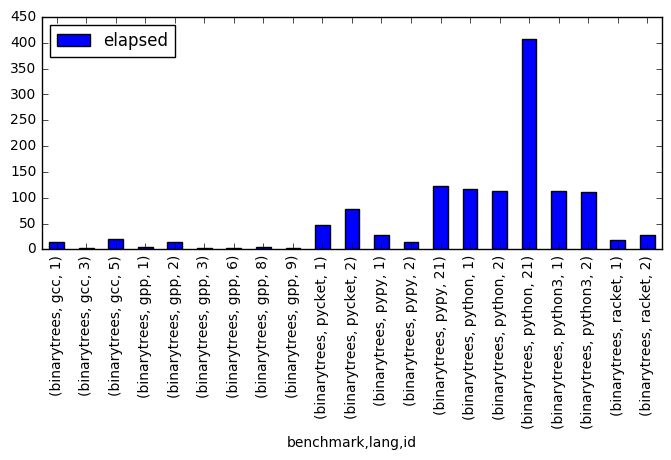

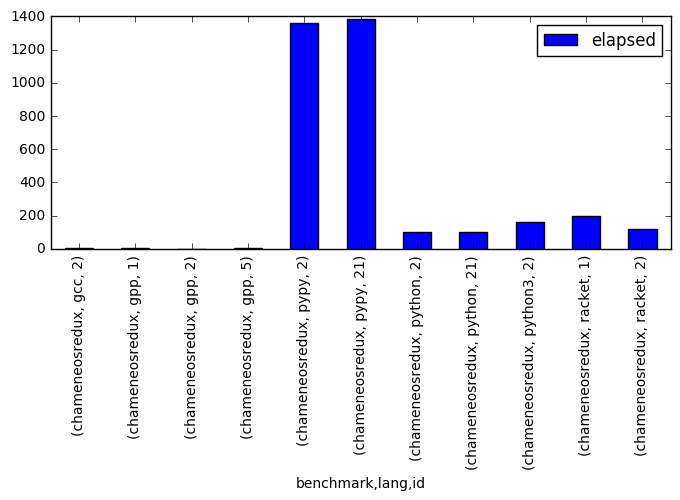

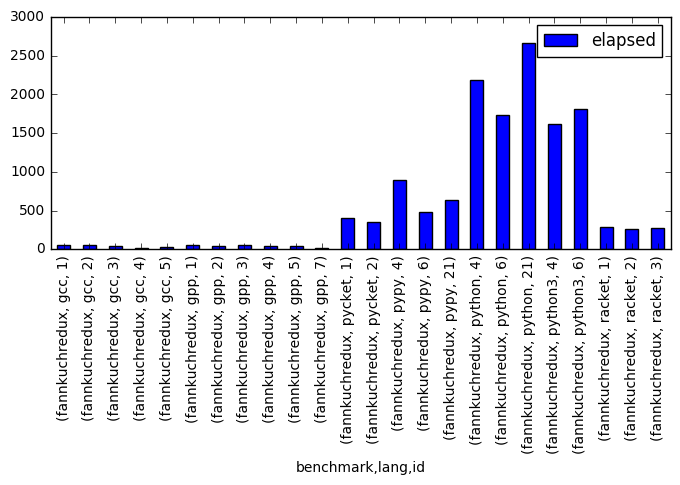

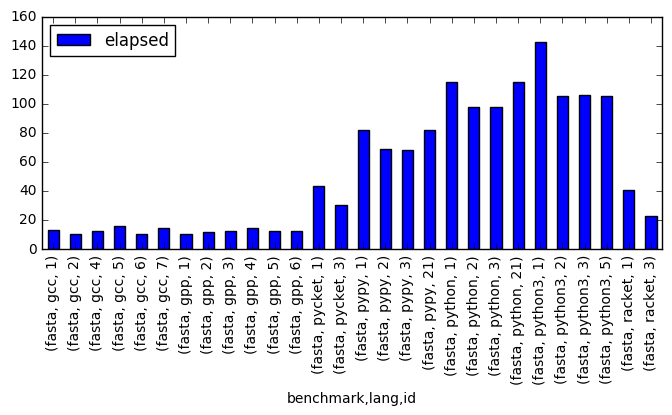

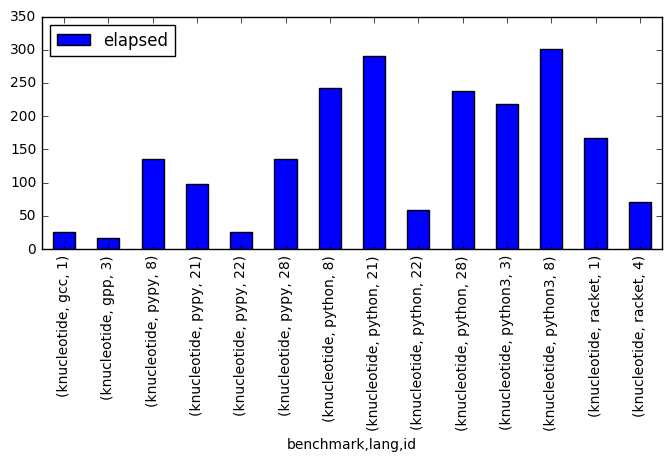

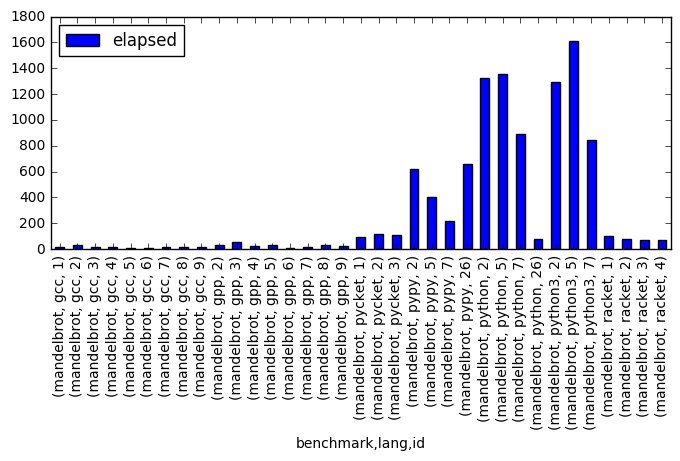

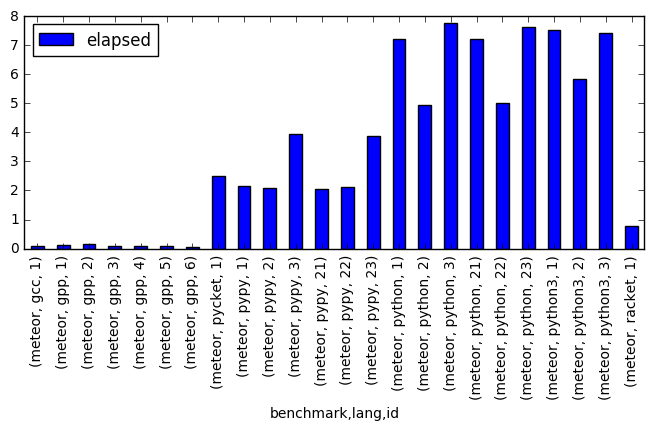

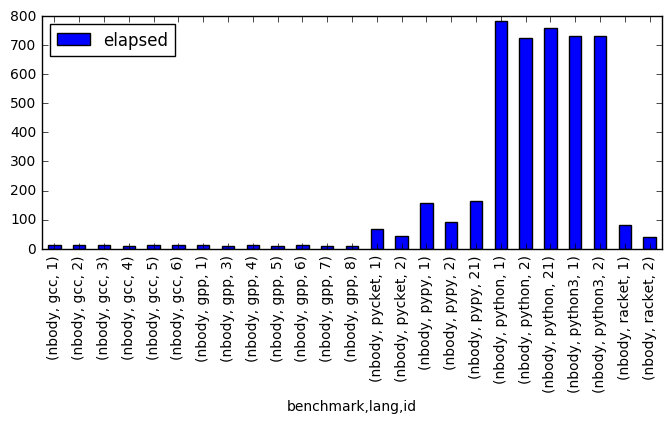

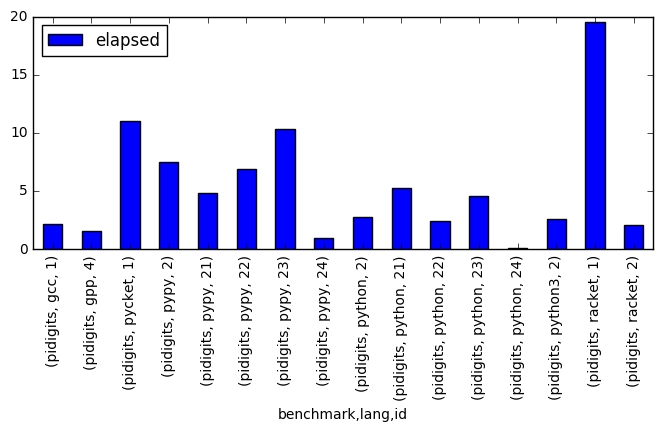

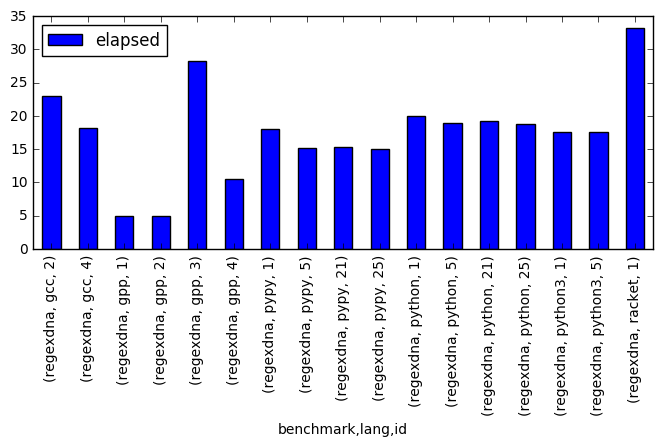

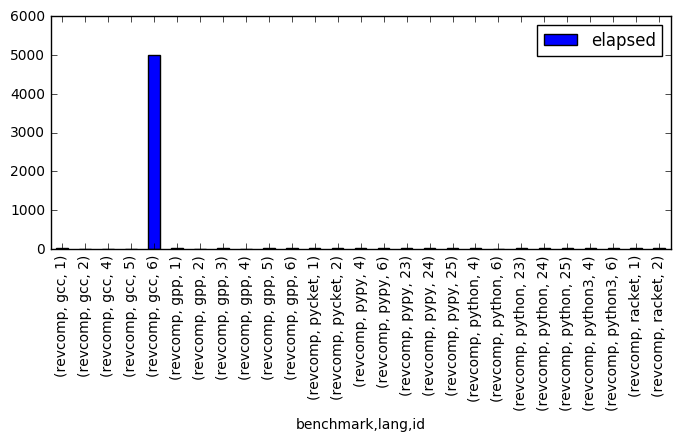

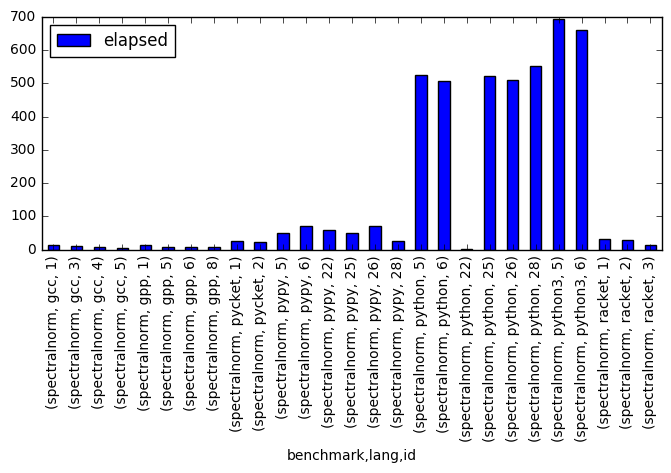

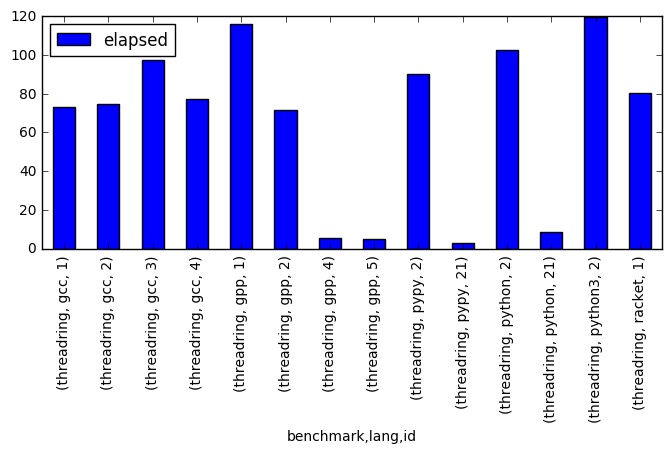

In [198]:
for benchmark in benchmarks:
    overall[overall.benchmark == benchmark].plot( kind="bar", x=["benchmark", "lang", "id"], y="elapsed", figsize=(8, 3) )

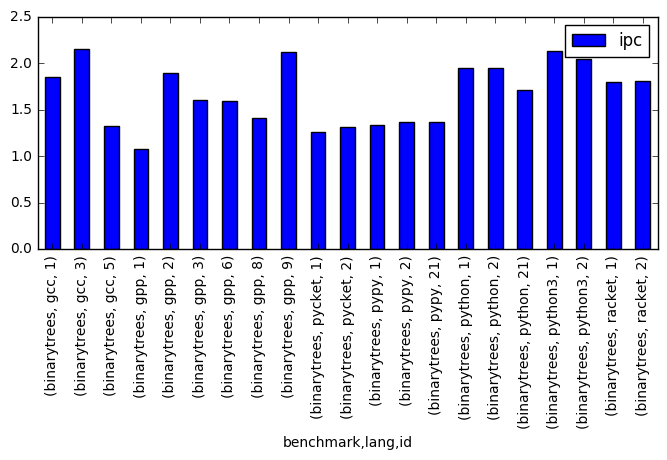

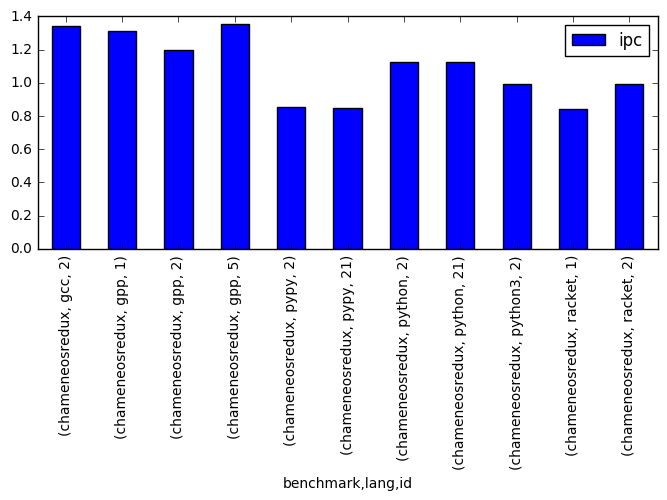

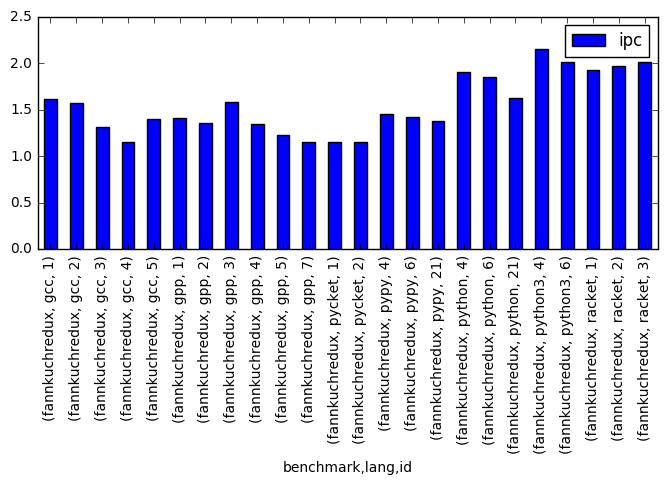

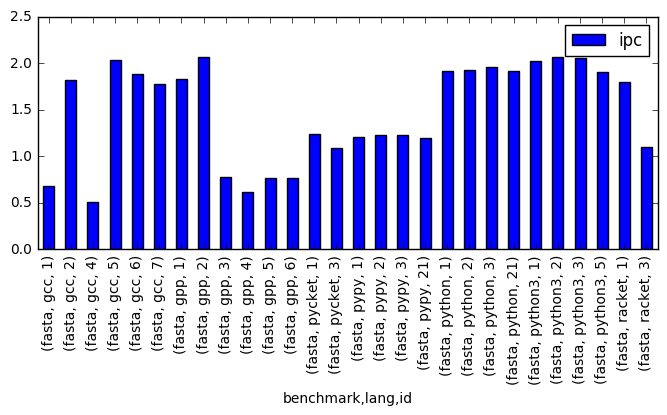

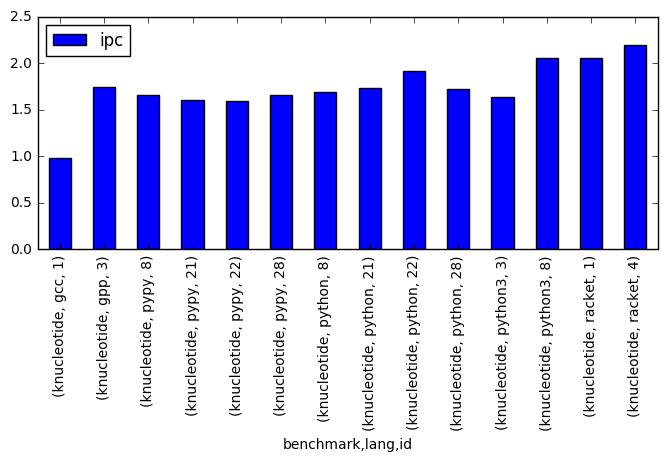

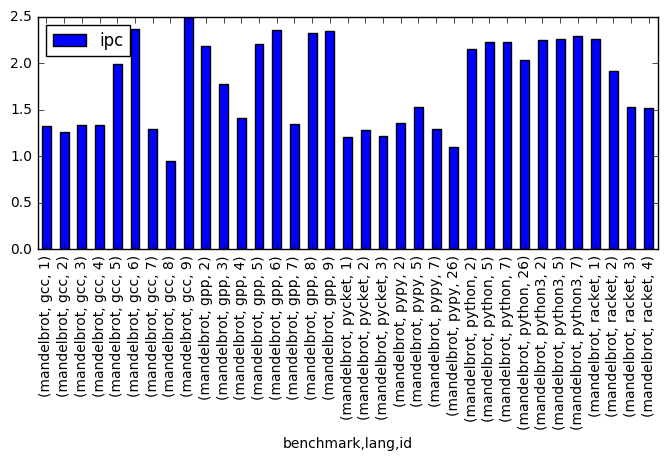

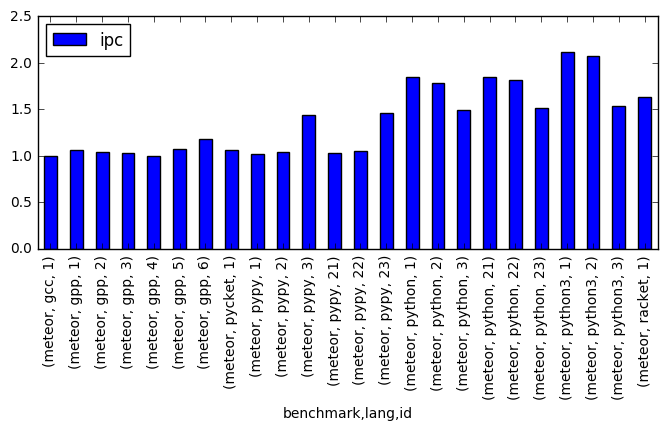

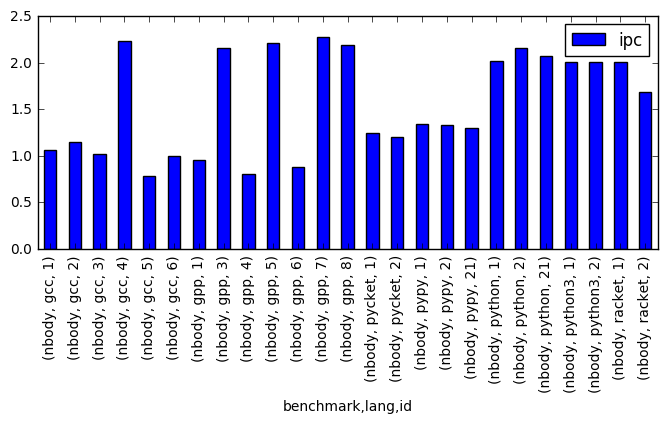

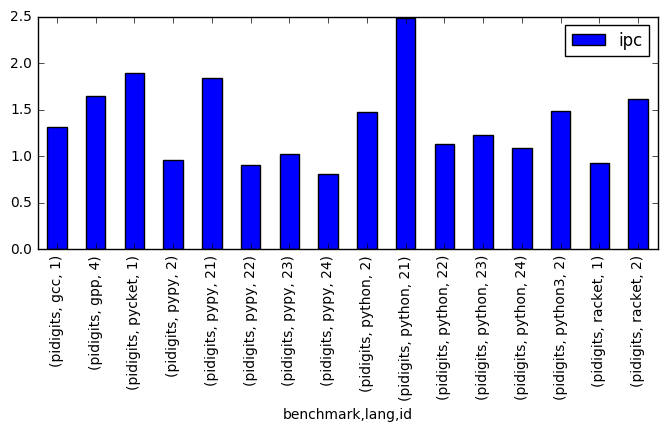

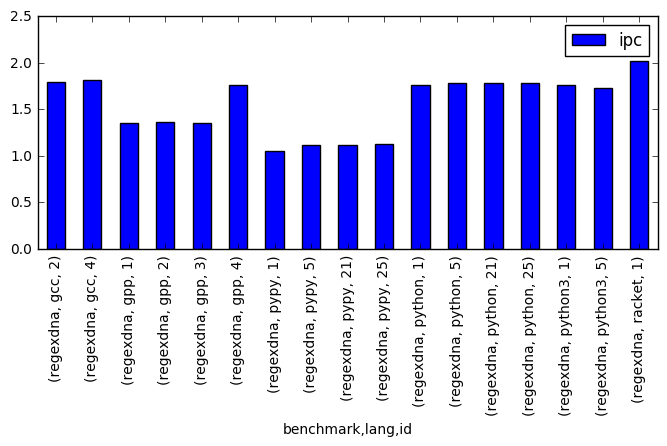

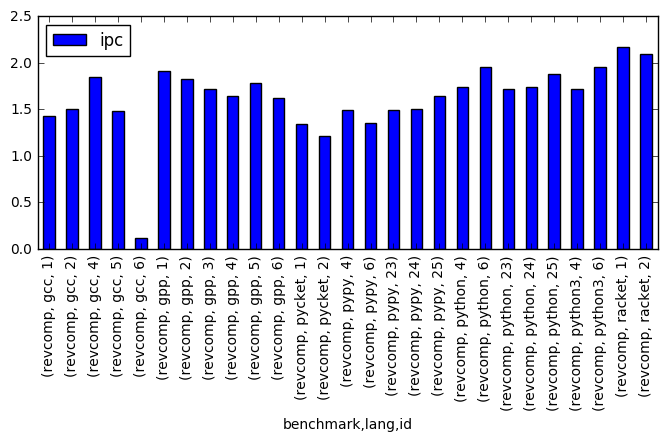

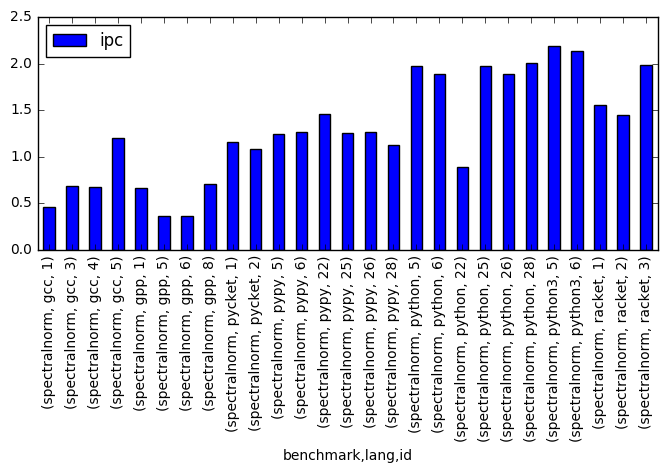

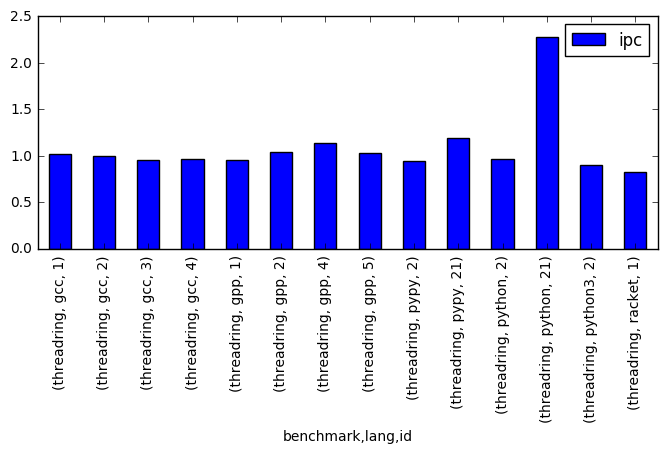

In [199]:
for benchmark in benchmarks:
    overall[overall.benchmark == benchmark].plot( kind="bar", x=["benchmark", "lang", "id"], y="ipc", figsize=(8, 3) )

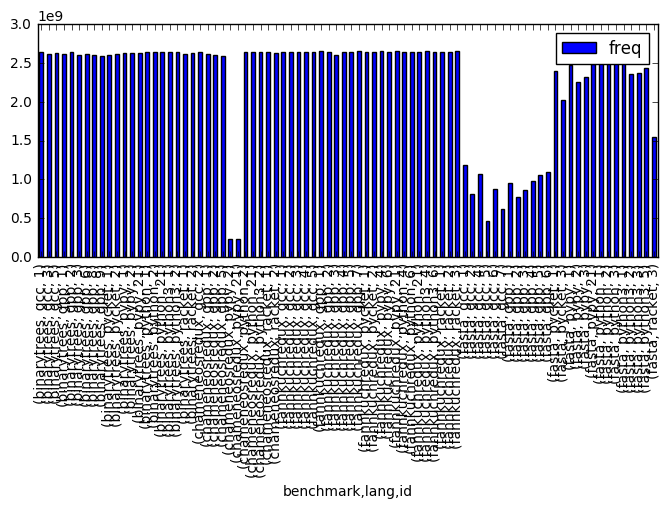

In [180]:
overall.plot( kind="bar", x=["benchmark", "lang", "id"], y="freq", figsize=(8, 3) )

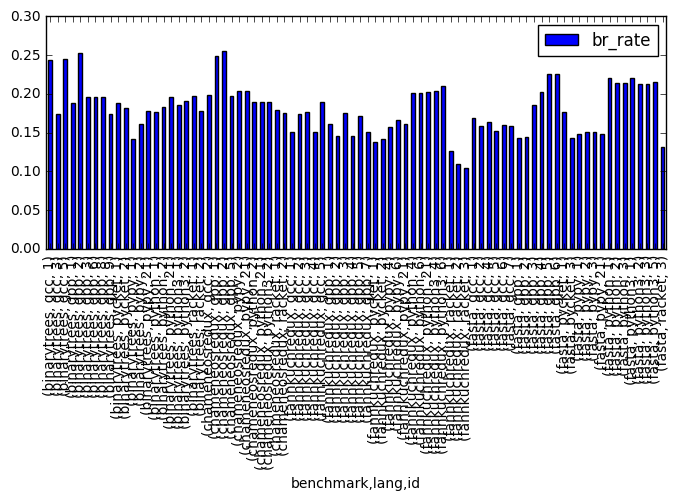

In [181]:
overall.plot( kind="bar", x=["benchmark", "lang", "id"], y="br_rate", figsize=(8, 3) )

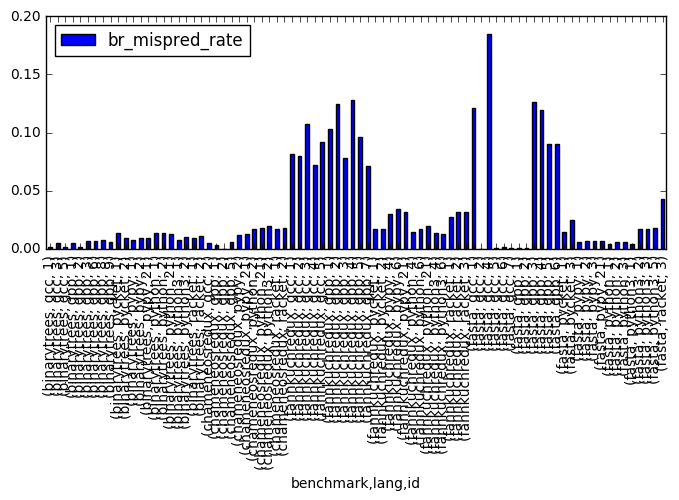

In [182]:
overall.plot( kind="bar", x=["benchmark", "lang", "id"], y="br_mispred_rate", figsize=(8, 3) )

In [204]:
overall_f = overall.sort_values("elapsed").groupby(["benchmark", "lang"], as_index=False).first()

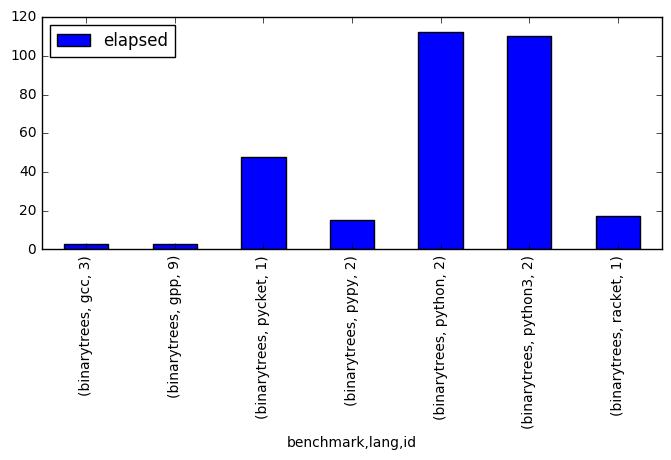

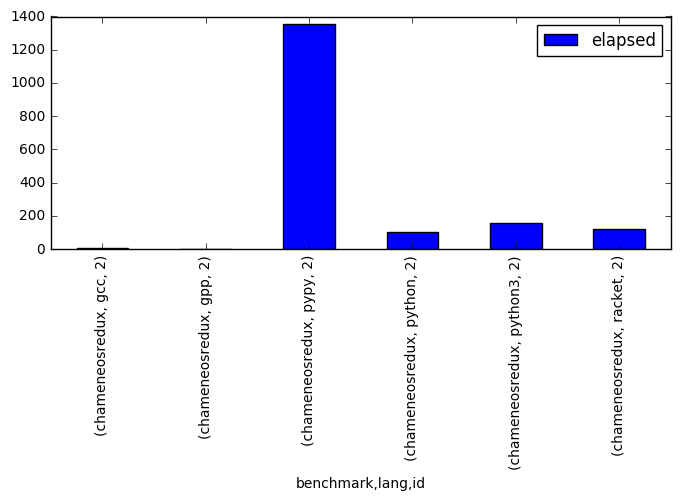

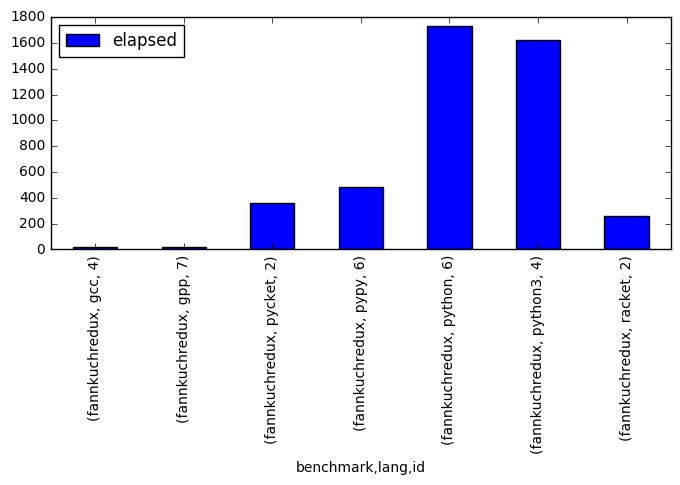

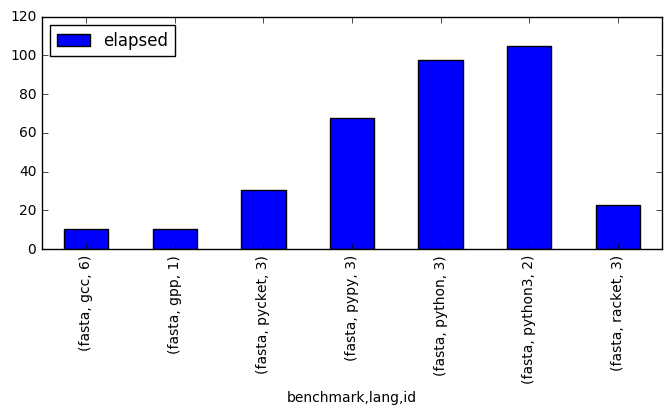

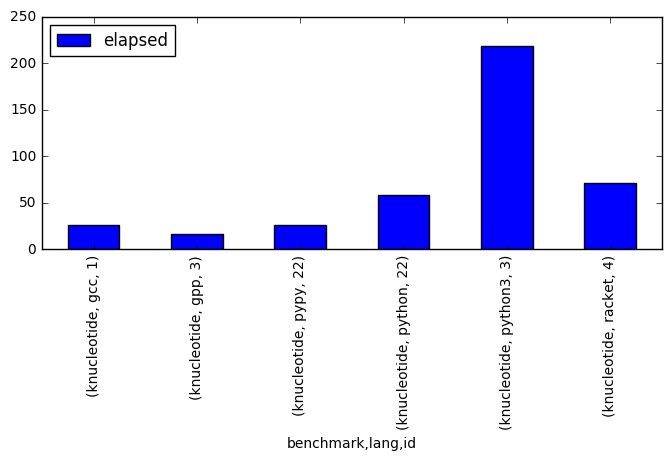

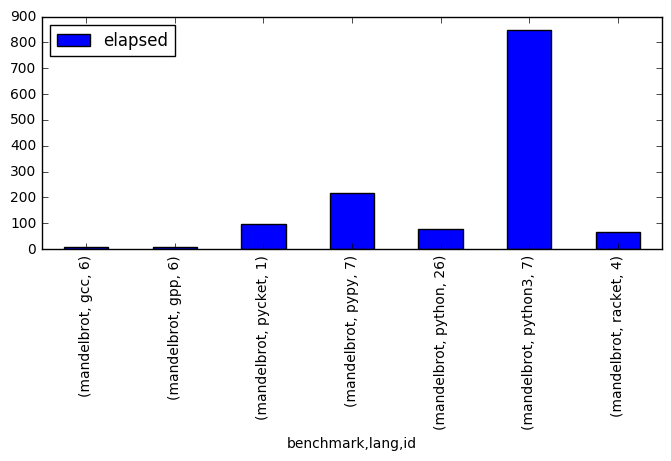

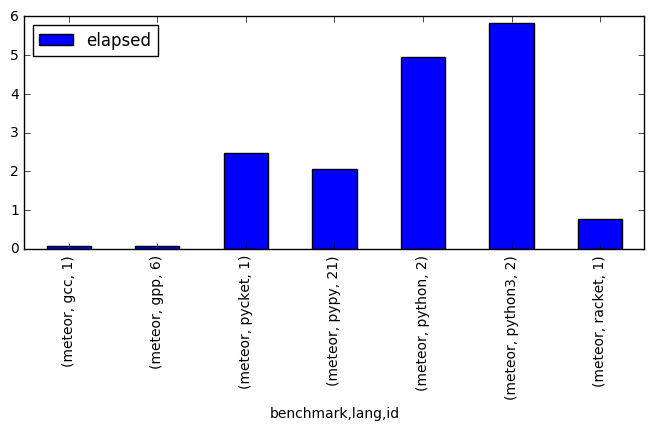

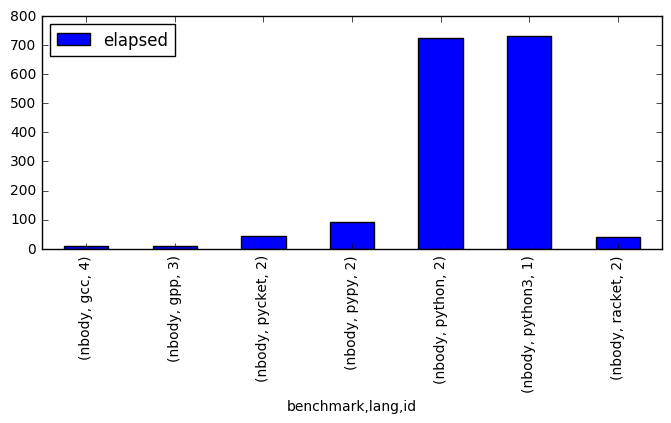

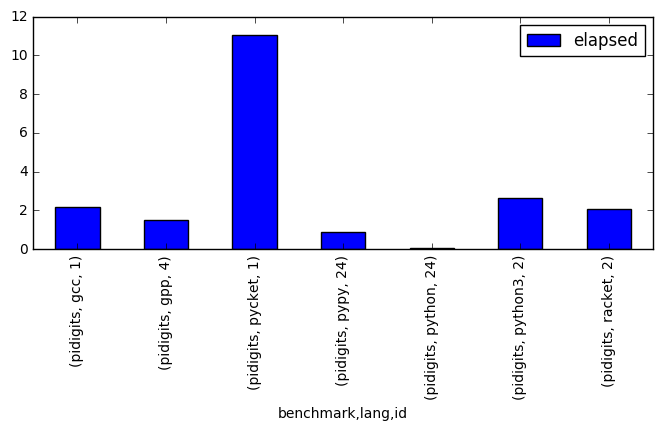

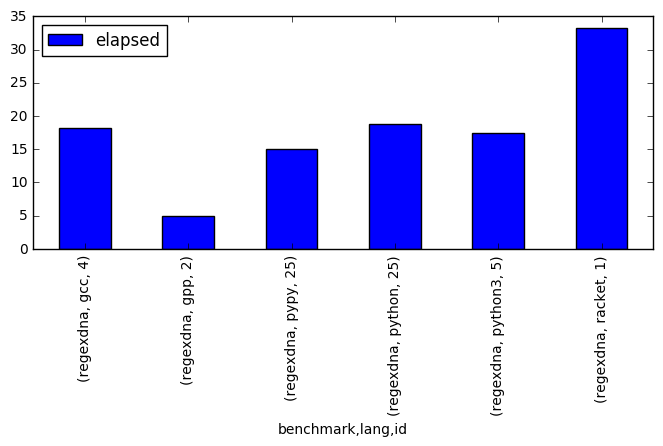

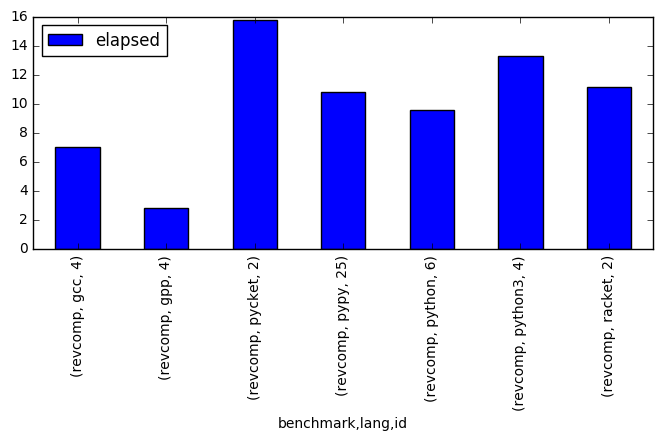

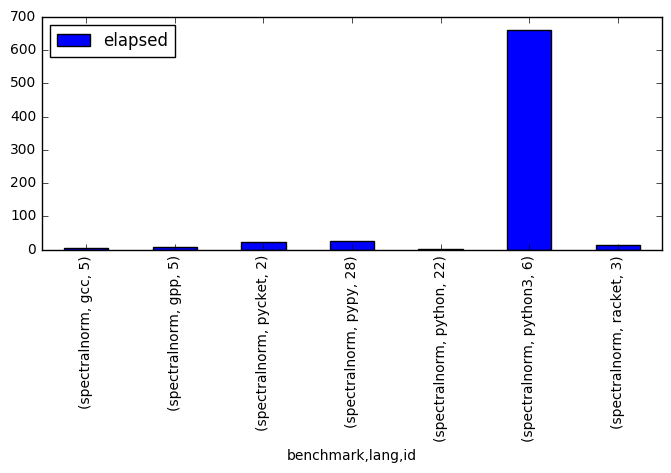

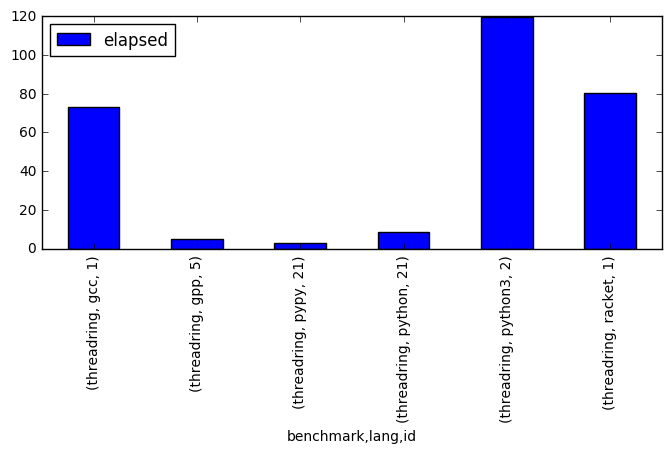

In [205]:
for benchmark in benchmarks:
    overall_f[overall_f.benchmark == benchmark].plot( kind="bar", x=["benchmark", "lang", "id"], y="elapsed", figsize=(8, 3) )

In [206]:
bt_gcc_3 = raw_dfs[("binarytrees", "gcc", 3)]

In [207]:
bt_gcc_3

,time,counts,units,events,dk1,dk2
0,0.100092,357201095,NaN,instructions,98025204,100.0
1,0.100092,253407430,NaN,cycles,98025204,100.0
2,0.100092,61063866,NaN,branches,98025204,100.0
3,0.100092,381641,NaN,branch-misses,98025204,100.0
4,0.200186,628427451,NaN,instructions,99438064,100.0
5,0.200186,264821038,NaN,cycles,99438064,100.0
6,0.200186,110539302,NaN,branches,99438064,100.0
7,0.200186,9059,NaN,branch-misses,99438064,100.0
8,0.300273,656013580,NaN,instructions,100104023,100.0
9,0.300273,266636093,NaN,cycles,100104023,100.0


In [216]:
bt_gcc_3.groupby(["time", "events"]).first()

counts  units        dk1    dk2
time     events                                           
0.100092 branch-misses     381641    NaN   98025204  100.0
         branches        61063866    NaN   98025204  100.0
         cycles         253407430    NaN   98025204  100.0
         instructions   357201095    NaN   98025204  100.0
0.200186 branch-misses       9059    NaN   99438064  100.0
         branches       110539302    NaN   99438064  100.0
         cycles         264821038    NaN   99438064  100.0
         instructions   628427451    NaN   99438064  100.0
0.300273 branch-misses        697    NaN  100104023  100.0
         branches       115576665    NaN  100104023  100.0
         cycles         266636093    NaN  100104023  100.0
         instructions   656013580    NaN  100104023  100.0
0.400346 branch-misses     112165    NaN  100084227  100.0
         branches       113185772    NaN  100084227  100.0
         cycles         266559853    NaN  100084227  100.0
         instructions   644997363    NaN  100084227  100.0
0.500422 branch-misses     159790    NaN  100025774  100.0
         branches       112078418    NaN  100025774  100.0
         cycles         266404984    NaN  100025774  100.0
         instructions   640155001    NaN  100025774  100.0
0.600497 branch-misses     226492    NaN  100091488  100.0
         branches       110446241    NaN  100091488  100.0
         cycles         266591853    NaN  100091488  100.0
         instructions   633025501    NaN  100091488  100.0
0.700572 branch-misses     333537    NaN   99595590  100.0
         branches       106428497    NaN   99595590  100.0
         cycles         265263999    NaN   99595590  100.0
         instructions   614749125    NaN   99595590  100.0
0.800650 branch-misses     333250    NaN   99905382  100.0
         branches       106799597    NaN   99905382  100.0
...                           ...    ...        ...    ...
2.101675 cycles         266506099    NaN  100067081  100.0
         instructions   550751768    NaN  100067081  100.0
2.201765 branch-misses     636323    NaN   99554328  100.0
         branches        97064885    NaN   99554328  100.0
         cycles         265109545    NaN   99554328  100.0
         instructions   553616917    NaN   99554328  100.0
2.301851 branch-misses     648727    NaN  100080596  100.0
         branches        97478279    NaN  100080596  100.0
         cycles         266554660    NaN  100080596  100.0
         instructions   555710905    NaN  100080596  100.0
2.401952 branch-misses     561308    NaN   99996302  100.0
         branches        83848478    NaN   99996302  100.0
         cycles         266285808    NaN   99996302  100.0
         instructions   484133069    NaN   99996302  100.0
2.502061 branch-misses     630022    NaN   99884050  100.0
         branches        87603606    NaN   99884050  100.0
         cycles         265942161    NaN   99884050  100.0
         instructions   507320120    NaN   99884050  100.0
2.602177 branch-misses     675172    NaN   99963610  100.0
         branches        86335558    NaN   99963610  100.0
         cycles         266188424    NaN   99963610  100.0
         instructions   498110872    NaN   99963610  100.0
2.702323 branch-misses     655193    NaN   91242200  100.0
         branches        74478206    NaN   91242200  100.0
         cycles         242912244    NaN   91242200  100.0
         instructions   426332251    NaN   91242200  100.0
2.733975 branch-misses        308    NaN      44994  100.0
         branches            3547    NaN      44994  100.0
         cycles             46057    NaN      44994  100.0
         instructions       19391    NaN      44994  100.0

[112 rows x 4 columns]

In [218]:
bt_gcc_3_pt = bt_gcc_3.pivot_table( values="counts", columns="events", index="time" )

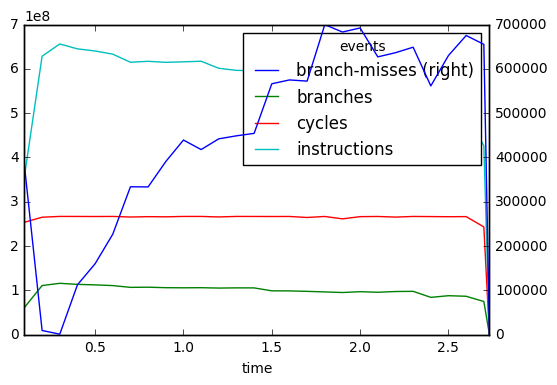

In [221]:
bt_gcc_3_pt.plot( secondary_y="branch-misses" )

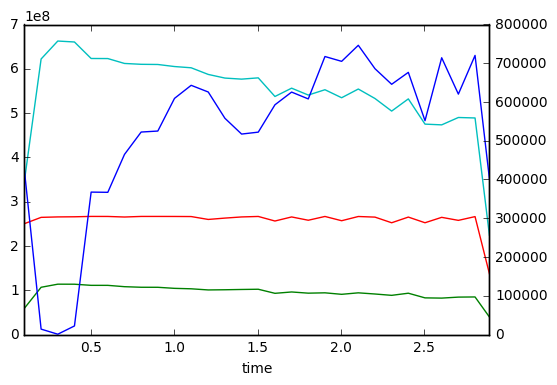

In [226]:
raw_dfs[("binarytrees", "gpp", 9)] \
    .pivot_table( values="counts", columns="events", index="time" ) \
    .plot( secondary_y="branch-misses", legend=False )

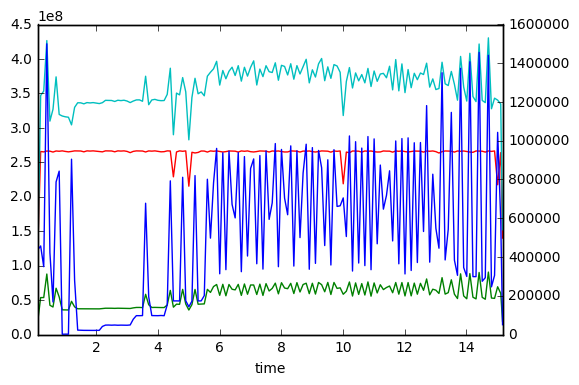

In [223]:
raw_dfs[("binarytrees", "pypy", 2)] \
    .pivot_table( values="counts", columns="events", index="time" ) \
    .plot( secondary_y="branch-misses", legend=False )

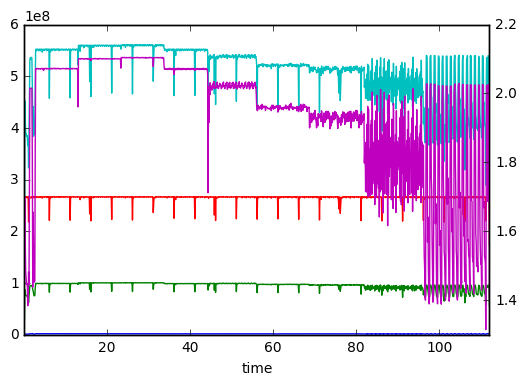

In [229]:
tmp_df = raw_dfs[("binarytrees", "python", 2)] \
    .pivot_table( values="counts", columns="events", index="time" )
tmp_df["ipc"] = tmp_df.instructions / tmp_df.cycles
tmp_df.plot( secondary_y="ipc", legend=False )

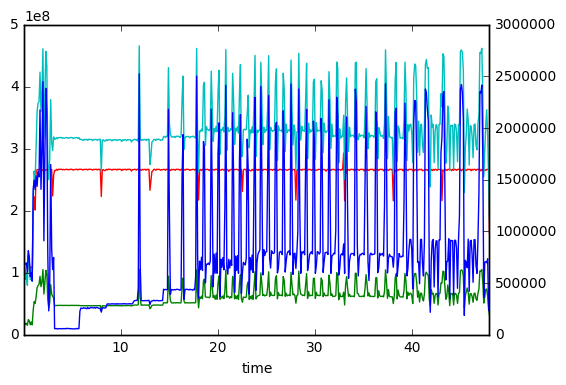

In [224]:
raw_dfs[("binarytrees", "pycket", 1)] \
    .pivot_table( values="counts", columns="events", index="time" ) \
    .plot( secondary_y="branch-misses", legend=False )

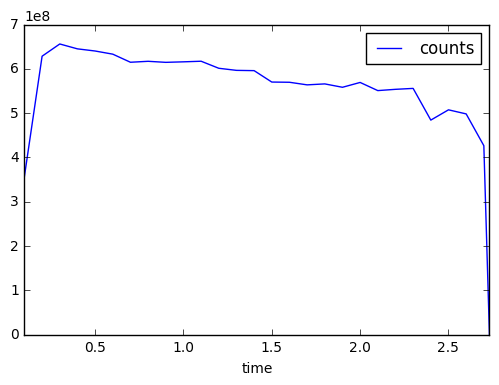

In [208]:
bt_gcc_3[bt_gcc_3.events == "instructions"].plot(x="time", y="counts")

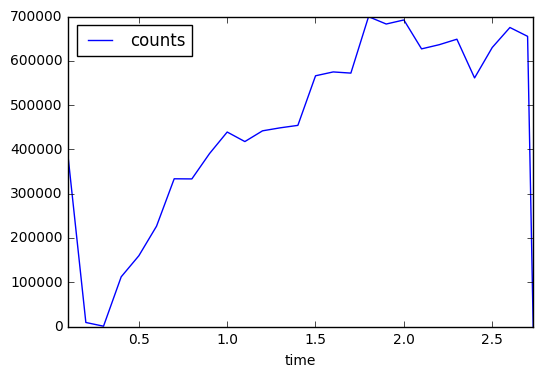

In [211]:
bt_gcc_3[bt_gcc_3.events == "branch-misses"].plot(x="time", y="counts")

In [61]:
raw_dfs[("binarytrees", "gcc", 1)].groupby("events")

KeyError: ('binarytrees', 'gcc', 1)

In [79]:
process_csv( "perf_out2/chameneosredux.pypy-2.pypy.csv" )

AttributeError: 'Series' object has no attribute 'counts'

In [155]:
raw = pd.read_csv( "perf_out2/chameneosredux.pypy-2.pypy.csv", header=None, names=perf_col_names, skiprows=2 )
# Get elapsed by getting the last entry.
elapsed = raw.iloc[-1].time
# Getting the total execution time and various metrics.
rawgb = raw.groupby( "events" ).sum()

In [160]:
raw2 = pd.read_csv( "perf_out2/binarytrees.gcc_run.csv", header=None, names=perf_col_names, skiprows=2 )


In [161]:
raw2

,time,counts,units,events,dk1,dk2
0,0.100074,500893030,NaN,instructions,98689601,100.0
1,0.100074,257571517,NaN,cycles,98689601,100.0
2,0.100074,93184769,NaN,branches,98689601,100.0
3,0.100074,145921,NaN,branch-misses,98689601,100.0
4,0.200213,489134348,NaN,instructions,99930838,100.0
5,0.200213,266102078,NaN,cycles,99930838,100.0
6,0.200213,90764395,NaN,branches,99930838,100.0
7,0.200213,211982,NaN,branch-misses,99930838,100.0
8,0.300324,491921786,NaN,instructions,99162089,100.0
9,0.300324,264040543,NaN,cycles,99162089,100.0


In [171]:
raw2.counts.dtype == "int64"

True

In [156]:
raw

,time,counts,units,events,dk1,dk2
0,0.100157,3151963,NaN,instructions,2849219,100.0
1,0.100157,4292867,NaN,cycles,2849219,100.0
2,0.100157,625218,NaN,branches,2849219,100.0
3,0.100157,20778,NaN,branch-misses,2849219,100.0
4,0.200340,<not counted>,NaN,instructions,0,100.0
5,0.200340,<not counted>,NaN,cycles,0,100.0
6,0.200340,<not counted>,NaN,branches,0,100.0
7,0.200340,<not counted>,NaN,branch-misses,0,100.0
8,0.300451,40410217,NaN,instructions,31071004,100.0
9,0.300451,67817722,NaN,cycles,31071004,100.0


In [159]:
raw[raw.counts != "<not counted>"]

,time,counts,units,events,dk1,dk2
0,0.100157,3151963,NaN,instructions,2849219,100.0
1,0.100157,4292867,NaN,cycles,2849219,100.0
2,0.100157,625218,NaN,branches,2849219,100.0
3,0.100157,20778,NaN,branch-misses,2849219,100.0
8,0.300451,40410217,NaN,instructions,31071004,100.0
9,0.300451,67817722,NaN,cycles,31071004,100.0
10,0.300451,7576787,NaN,branches,31071004,100.0
11,0.300451,165705,NaN,branch-misses,31071004,100.0
12,0.400563,21880237,NaN,instructions,19542100,100.0
13,0.400563,29101954,NaN,cycles,19542100,100.0


In [146]:
raw = raw.replace("<not counted>", np.nan)
raw.counts = raw.counts.astype(int)

In [147]:
def foo( x ):
    s = 0
    print "a", x.name
    n = 0
    try:
        for i in x:
            if type(i) == str:
                print "str: '{}' n: {}".format( i, n )
            s += i
            n += 1
    except Exception as e:
        print e
    print "b", s
    return s
raw.groupby( "events" ).aggregate(foo)

a time
b 9208672.26267
a time
b 9208672.26267
a time
b 9208672.26267
a time
b 9208672.26267
a counts
b 650850553
a counts
b 53990458873
a counts
b 309919567485
a counts
b 265682766881
a units
b nan
a units
b nan
a units
b nan
a units
b nan
a dk1
b 236226628556
a dk1
b 236226628556
a dk1
b 236226628556
a dk1
b 236226628556
a dk2
b 1356400.0
a dk2
b 1356400.0
a dk2
b 1356400.0
a dk2
b 1356400.0


,time,counts,units,dk1,dk2
events,,,,,
branch-misses,9.208672e+06,650850553,NaN,236226628556,1356400.0
branches,9.208672e+06,53990458873,NaN,236226628556,1356400.0
cycles,9.208672e+06,309919567485,NaN,236226628556,1356400.0
instructions,9.208672e+06,265682766881,NaN,236226628556,1356400.0


In [137]:
raw

,time,counts,units,events,dk1,dk2
0,0.100157,3151963,NaN,instructions,2849219,100.0
1,0.100157,4292867,NaN,cycles,2849219,100.0
2,0.100157,625218,NaN,branches,2849219,100.0
3,0.100157,20778,NaN,branch-misses,2849219,100.0
4,0.200340,0,NaN,instructions,0,100.0
5,0.200340,0,NaN,cycles,0,100.0
6,0.200340,0,NaN,branches,0,100.0
7,0.200340,0,NaN,branch-misses,0,100.0
8,0.300451,40410217,NaN,instructions,31071004,100.0
9,0.300451,67817722,NaN,cycles,31071004,100.0
